Due to the limitation on file length, this code sample only includes a portion of the code. The complete project code is available on GitHub.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import pandas as pd
import os

In [21]:
# Reads the raw data then drops any rows with missing values
df_raw = pd.read_csv('data_banknote_authentication.txt', 
                     names=['variance', 'skewness', 'curtosis', 'entropy', 'class'], 
                     header=None)
df = df_raw.copy(deep=True)
df = df.dropna()
# Extracts class_names, which are the unique values in the class label column of df
label_col_name = 'class'
feature_col_names = [col for col in df_raw.columns.tolist() if col!=label_col_name]
class_names = df[label_col_name].unique().tolist()
df[label_col_name] = 2. * np.array([class_names.index(x) for x in df[label_col_name]]) - 1.0

In [22]:
df_shuffled = df.sample(frac=1, random_state=111).reset_index(drop=True)
all_features = df_shuffled.loc[:, df_shuffled.columns != label_col_name].values
all_labels = df_shuffled[label_col_name].values
# Filter columns that meet the criterion
valid_cols = []
for col_idx in range(all_features.shape[1]):
    if np.unique(all_features[:,col_idx].reshape(-1)).size > 5:
        valid_cols.append(col_idx)
all_features = all_features[:, valid_cols]
# Splitting the data to training set and validation set
def train_val_test_split(all_features, all_labels, train_frac=0.4, val_frac=0.3):
    train_cnt = int(train_frac * all_features.shape[0])
    val_cnt = int(val_frac * all_features.shape[0])
    train_features, train_labels = all_features[:train_cnt, :], all_labels[:train_cnt]
    val_features, val_labels = all_features[train_cnt:(train_cnt+val_cnt), :], all_labels[train_cnt:(train_cnt+val_cnt)]
    test_features, test_labels = all_features[(train_cnt+val_cnt):, :], all_labels[(train_cnt+val_cnt):]
    return train_features, train_labels, val_features, val_labels, test_features, test_labels
splitted_data = train_val_test_split(all_features, all_labels, train_frac=0.4, val_frac=0.3)
train_features, train_labels, val_features, val_labels, test_features, test_labels = splitted_data

In [23]:
# Help Functions to Build SVM Trainer
def normalize_feats(train_features, some_features):
    mu_train = np.mean(train_features, axis=0)
    sigma_train = np.std(train_features, axis=0)

    some_features_normalized = (some_features - mu_train) / sigma_train
    return some_features_normalized

def e_term(x_batch, y_batch, a, b):
    e_batch = 1 - y_batch * (np.dot(x_batch, a) + b)
    return e_batch

def loss_terms_ridge(e_batch, a, lam):
    hinge_loss = np.mean(np.maximum(0, e_batch))
    ridge_loss = lam/2 * np.dot(a.T, a).item()
    return np.array((hinge_loss, ridge_loss))

def a_gradient_ridge(x_batch, y_batch, e_batch, a, lam):
    active_hinge = (e_batch > 0).astype(float)
    hinge_grad = - (x_batch * y_batch * active_hinge).mean(axis=0, keepdims=True).T
    ridge_grad = lam * a
    grad_a = hinge_grad + ridge_grad
    return grad_a

def b_derivative(y_batch, e_batch):
    return np.mean(np.where(e_batch >= 0, -y_batch, 0))

In [24]:
def get_acc(a, b, feats_nomalized, labels):
    pred = (feats_nomalized @ a + b) >= 0.
    pred = 2 * pred - 1
    acc = (pred.reshape(-1) == labels.reshape(-1)).mean()
    return acc

def svm_trainer(train_features, train_labels, val_features, val_labels, heldout_size=50,
                batch_size=1, num_epochs=100, num_steps=300, eval_interval = 30, 
                lambda_list=[1e-3, 1e-2, 1e-1, 2e-1], eta_tuner=lambda epoch: 1./(0.01 * epoch + 500.),
                regularization = 'ridge'):
    train_features_normalized = normalize_feats(train_features, train_features)
    val_features_normalized = normalize_feats(train_features, val_features)
    np_random = np.random.RandomState(111)
    
    if regularization == 'ridge':
        a_gradient = a_gradient_ridge
        loss_terms = loss_terms_ridge

    train_progress = np.arange(0., num_epochs, eval_interval/num_steps)
    heldout_accs = np.zeros((len(lambda_list), train_progress.size))
    weight_magnitudes = np.zeros((len(lambda_list), train_progress.size))
    hinge_losses = np.zeros((len(lambda_list), train_progress.size))
    reg_losses = np.zeros((len(lambda_list), train_progress.size))
    val_accs = np.zeros(len(lambda_list))

    all_a = np.zeros((len(lambda_list), train_features_normalized.shape[1]))
    all_b = np.zeros(len(lambda_list))

    for lam_idx, lam in enumerate(lambda_list):
        a = np.zeros((train_features_normalized.shape[1], 1))
        b = 0.

        eval_idx = 0
        for epoch in range(num_epochs):
            eta = eta_tuner(epoch)

            heldout_size = min(heldout_size, train_features_normalized.shape[0]//2)

            heldout_indicator = np.arange(train_features_normalized.shape[0]) < heldout_size

            np_random.shuffle(heldout_indicator)

            heldout_feats = train_features_normalized[heldout_indicator,:]

            heldout_labels = train_labels[heldout_indicator]

















            non_heldout_feats = train_features_normalized[heldout_indicator==False,:]
            non_heldout_labels = train_labels[heldout_indicator==False]
            batch_size = min(batch_size, non_heldout_feats.shape[0])
            for step in range(num_steps):
                rand_unifs = np_random.uniform(0, 1, size=non_heldout_feats.shape[0])
                batch_thresh = np.percentile(rand_unifs, 100. * batch_size / non_heldout_feats.shape[0])
                batch_indices = (rand_unifs<=batch_thresh)
                x_batch = non_heldout_feats[batch_indices,:]
                y_batch = non_heldout_labels[batch_indices].reshape(-1,1)

                e_batch = e_term(x_batch, y_batch, a, b)
                hinge_loss, reg_loss = loss_terms(e_batch, a, lam)
                grad_a = a_gradient(x_batch, y_batch, e_batch, a, lam)
                grad_b = b_derivative(y_batch, e_batch)

                if step % eval_interval == 0:
                    heldout_acc = get_acc(a, b, heldout_feats, heldout_labels)
                    heldout_accs[lam_idx, eval_idx] = heldout_acc
                    if regularization == 'ridge':
                        weight_magnitudes[lam_idx, eval_idx] = np.sum(a**2)
                    hinge_losses[lam_idx, eval_idx] = hinge_loss
                    reg_losses[lam_idx, eval_idx] = reg_loss
                    eval_idx += 1
                    if step % (5 * eval_interval) == 0:
                        print('.', end='')

                a = a - eta * grad_a
                b = b - eta * grad_b
        
        val_acc = get_acc(a, b, val_features_normalized, val_labels)
        val_accs[lam_idx] = val_acc
        all_a[lam_idx, :] = a.reshape(-1)
        all_b[lam_idx] = b
        print((f'\nlambda={lam} yielded a validation accuracy of %.3f '%(100. * val_acc)) + '%') 
        
    return_dict = dict(all_a=all_a, all_b=all_b, train_progress=train_progress, regularization=regularization,
                       train_features=train_features, train_labels=train_labels, 
                       val_features=val_features, val_labels=val_labels,
                       lambda_list=lambda_list, val_accs=val_accs, hinge_losses=hinge_losses,
                       weight_magnitudes=weight_magnitudes, heldout_accs=heldout_accs)
    return return_dict

In [25]:
def ema(vec, alpha=0.99):
    out = [vec[0]]
    last_val = vec[0]
    for val in vec[1:]:
        last_val = val*(1-alpha) + alpha*last_val
        out.append(last_val)
    return np.array(out)
    
def generate_plots(training_info, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.99):
    assert 0 <= heldout_acc_smoothing < 1
    assert 0 <= loss_smoothing < 1
    assert 0 <= weight_smoothing < 1
    all_a = training_info['all_a']
    all_b = training_info['all_b']
    train_progress = training_info['train_progress']
    lambda_list = training_info['lambda_list']
    val_accs = training_info['val_accs']
    hinge_losses = training_info['hinge_losses']
    weight_magnitudes = training_info['weight_magnitudes']
    heldout_accs = training_info['heldout_accs']
    regularization = training_info['regularization']
    
    fig, axes = plt.subplots(2, 2, figsize=(12,10), dpi=90)
    ax = axes[0,0]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(weight_magnitudes[lam_idx,:], weight_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weight Magnitude')
    if weight_smoothing:
        ax.set_title('(Moving Average of) Weight Magnitudes During Training')
    else:
        ax.set_title('Weight Magnitudes During Training')
    
    ax.legend()

    ax = axes[0,1]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(heldout_accs[lam_idx,:], heldout_acc_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Held-out Accuracy')
    if heldout_acc_smoothing:
        ax.set_title('(Moving Average of) Held-out Accuracy During Training')
    else:
        ax.set_title('Held-out Accuracy During Training')
    _ = ax.legend()
    
    ax = axes[1,0]
    ax.plot(lambda_list, val_accs)
    ax.set_xscale('log')
    ax.set_xlabel('Regularization coefficient')
    ax.set_ylabel('Validation Accuracy')
    _ = ax.set_title('Validation Accuracy')
    
    ax = axes[1,1]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(hinge_losses[lam_idx,:], loss_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if loss_smoothing:
        ax.set_title('(Moving Average of) Hinge Loss During Training')
    else:
        ax.set_title('Hinge Loss During Training')
    _ = ax.legend()

In [ ]:
def get_test_accuracy(test_features, test_labels, training_info):
    train_features = training_info['train_features']
    val_accs = training_info['val_accs']
    all_a = training_info['all_a']
    all_b = training_info['all_b']
    lambda_list = training_info['lambda_list']
    test_features_normalized = normalize_feats(train_features, test_features)
    best_lam_idx = np.argmax(val_accs)
    best_a = all_a[best_lam_idx, :].reshape(-1,1)
    best_b = all_b[best_lam_idx]
    test_acc = get_acc(best_a, best_b, test_features_normalized, test_labels)
    print(f'Best lambda was chosen to be {lambda_list[best_lam_idx]}')
    print((f'The resulting test accuracy was %.3f '%(100. * test_acc)) + '%')

In [26]:
splitted_data = train_val_test_split(all_features, all_labels, train_frac=0.5, val_frac=0.25)
train_features_pr, train_labels_pr, val_features_pr, val_labels_pr, test_features_pr, test_labels_pr = splitted_data
training_info_plain_ridge = svm_trainer(train_features_pr, train_labels_pr, val_features_pr, val_labels_pr, 
                                        heldout_size=50, batch_size=32, num_epochs=50, num_steps=300, 
                                        eval_interval = 30, eta_tuner = lambda epoch: 1./(0.01 * epoch + 50.),
                                        lambda_list=[0., 1e-3, 1e-2, 1e-1, 1e0], 
                                        regularization='ridge')

................

....................................................................................
lambda=0.0 yielded a validation accuracy of 96.793 %
....................................................................................................
lambda=0.001 yielded a validation accuracy of 96.793 %
....................................................................................................
lambda=0.01 yielded a validation accuracy of 96.793 %
....................................................................................................
lambda=0.1 yielded a validation accuracy of 95.627 %
....................................................................................................
lambda=1.0 yielded a validation accuracy of 90.379 %


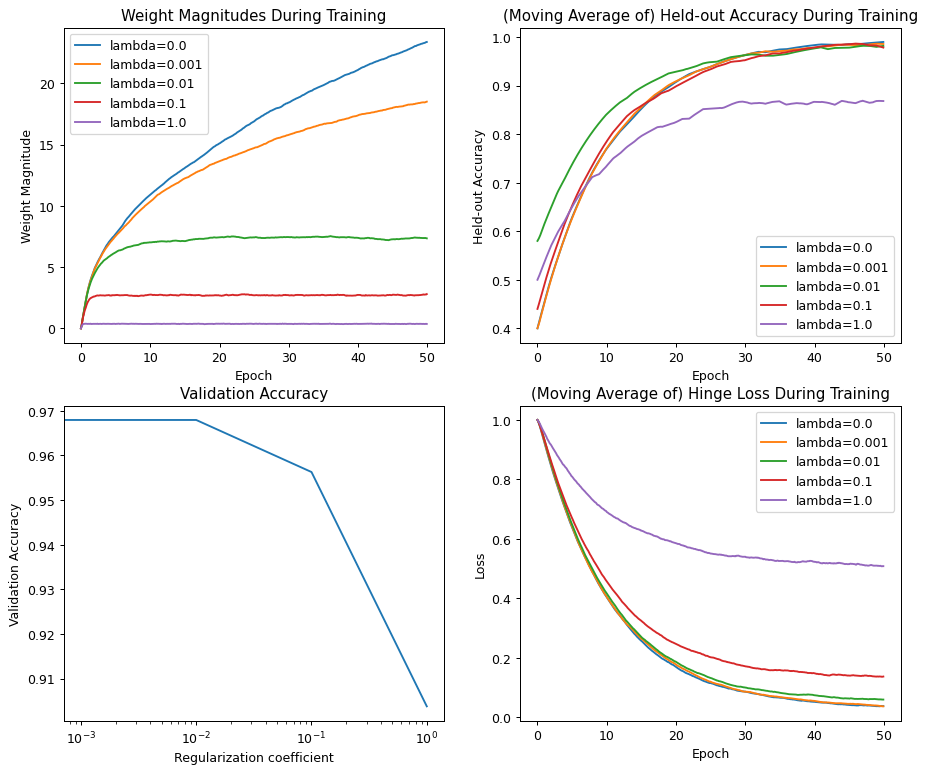

In [27]:
generate_plots(training_info_plain_ridge, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.)

In [28]:
get_test_accuracy(test_features_pr, test_labels_pr, training_info_plain_ridge)

Best lambda was chosen to be 0.0
The resulting test accuracy was 99.125 %
